In [1]:
#Go to account in kaggle.create newapi token and json file is downloaded.upload it(find in downloads)
from google.colab import files

uploaded = files.upload()
print(uploaded) #{'kaggle.json': b'{"username":"raghavendraredd1","key":"a0cc13e433266c6685556806c4740de6"}'}
for fn in uploaded.keys():
  print("User uploaded file '{name}' with length {length} bytes".format(name=fn,length=len(uploaded[fn])))

#then move kaggle.json into folder where api expects to find it
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
#Ensure kaggle.json is in the location ~/.kaggle/kaggle.json to use the API.

Saving kaggle.json to kaggle.json
{'kaggle.json': b'{"username":"raghavendraredd1","key":"a0cc13e433266c6685556806c4740de6"}'}
User uploaded file 'kaggle.json' with length 72 bytes


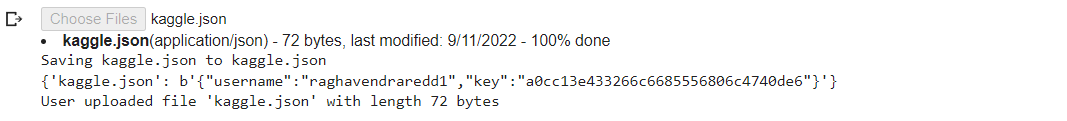

In [2]:
!kaggle datasets download -d deadskull7/fer2013 
#Copy API command

 95% 92.0M/96.6M [00:00<00:00, 178MB/s]
100% 96.6M/96.6M [00:00<00:00, 169MB/s]


In [3]:
!unzip fer2013.zip

Archive:  fer2013.zip
replace fer2013.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [4]:
!rm fer2013.zip

### Importing Required Libraries

In [6]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
import keras.utils
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
import random
import seaborn as sns
import warnings
warnings.simplefilter("ignore")
from tensorflow.keras.models import Sequential
from keras import regularizers
from keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax
from keras.utils.vis_utils import plot_model
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization,MaxPooling2D,Activation,Input,GlobalMaxPooling2D
from keras.models import Model
from sklearn.metrics import accuracy_score
from keras.regularizers import l1, l2
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [7]:
data=pd.read_csv('fer2013.csv')
data

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
...,...,...,...
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
 2   Usage    35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


### Missing Values Check

In [9]:
data.isnull().sum()

emotion    0
pixels     0
Usage      0
dtype: int64

In [10]:
data.shape

(35887, 3)

### Data Distribution

In [11]:
data['emotion'].value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

In [13]:
class_labels=['Angry','Disgust','Fear','Happy','Sad','Surprise','Neutral']

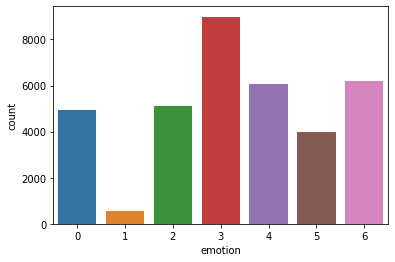

In [19]:
sns.countplot(data['emotion'])
plt.show()

In [20]:
y = [list(data['emotion']).count(i) for i in np.unique(data['emotion'])]
y

[4953, 547, 5121, 8989, 6077, 4002, 6198]

In [21]:
np.unique(data['emotion'])

array([0, 1, 2, 3, 4, 5, 6])

In [22]:
fig = px.bar(x = class_labels,
             y = [list(data['emotion']).count(i) for i in np.unique(data['emotion'])] , 
             color = np.unique(data['emotion']) ,
             color_continuous_scale="Emrld") 
fig.update_xaxes(title="Emotions")
fig.update_yaxes(title = "Number of Images")
fig.update_layout(showlegend = True,
    title = {
        'text': 'Train Data Distribution ',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

In [23]:
labels = to_categorical(data[['emotion']], num_classes=7)
labels

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

In [24]:
train_pixels = data["pixels"].astype(str).str.split(" ").tolist()
train_pixels = np.uint8(train_pixels)
train_pixels

array([[ 70,  80,  82, ..., 106, 109,  82],
       [151, 150, 147, ..., 193, 183, 184],
       [231, 212, 156, ...,  88, 110, 152],
       ...,
       [ 17,  17,  16, ..., 154, 133, 113],
       [ 30,  28,  28, ...,  35,  30,  28],
       [ 19,  13,  14, ..., 189, 199, 201]], dtype=uint8)

In [26]:
train_pixels.shape

(35887, 2304)

In [27]:
train_pixels=train_pixels/255
train_pixels[:5]

array([[0.2745098 , 0.31372549, 0.32156863, ..., 0.41568627, 0.42745098,
        0.32156863],
       [0.59215686, 0.58823529, 0.57647059, ..., 0.75686275, 0.71764706,
        0.72156863],
       [0.90588235, 0.83137255, 0.61176471, ..., 0.34509804, 0.43137255,
        0.59607843],
       [0.09411765, 0.1254902 , 0.14117647, ..., 0.55686275, 0.56078431,
        0.55686275],
       [0.01568627, 0.        , 0.        , ..., 0.11764706, 0.11372549,
        0.11764706]])

In [19]:
'''train_pixels3 = train_pixels.reshape((35887*2304,1))
scaler = StandardScaler()
train_pixels3 = scaler.fit_transform(train_pixels3)
train_pixels3
train_pixels3 = train_pixels3.reshape((35887, 48, 48,1))
train_pixels3[:3]'''

'train_pixels3 = train_pixels.reshape((35887*2304,1))\nscaler = StandardScaler()\ntrain_pixels3 = scaler.fit_transform(train_pixels3)\ntrain_pixels3\ntrain_pixels3 = train_pixels3.reshape((35887, 48, 48,1))\ntrain_pixels3[:3]'

In [28]:
import math
math.sqrt(len(data.pixels[0].split(' ')))

48.0

In [29]:
train_pixels = train_pixels.reshape((35887, 48, 48,1))

In [22]:
X_train, X_test, y_train, y_test = train_test_split(train_pixels, labels, test_size=0.15, shuffle=True)

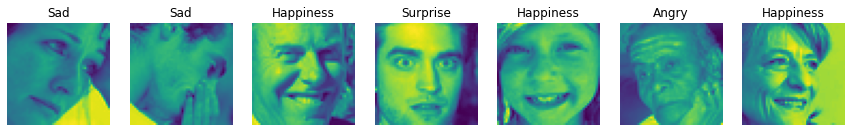

In [30]:
plt.figure(figsize=(15,23))
label_dict = {0 : 'Angry', 1 : 'Disgust', 2 : 'Fear', 3 : 'Happiness', 4 : 'Sad', 5 : 'Surprise', 6 : 'Neutral'}
i = 1
for i in range (7):
    img = np.squeeze(X_train[i])
    plt.subplot(1,7,i+1)
    plt.imshow(img)
    index = np.argmax(y_train[i])
    plt.title(label_dict[index])
    plt.axis('off')
    i += 1
plt.show()

In [40]:
datagen = ImageDataGenerator(  width_shift_range = 0.1,
                               height_shift_range = 0.1,
                               horizontal_flip = True,
                               zoom_range = 0.2,validation_split=0.2)
valgen = ImageDataGenerator( ) 

In [41]:
datagen.fit(X_train)
valgen.fit(X_test)

In [42]:
train_generator = datagen.flow(X_train, y_train, batch_size=64)
val_generator = valgen.flow(X_test, y_test, batch_size=64)

In [43]:
def cnn_model():

  model= tf.keras.models.Sequential()
  model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48,1))) #32*3*3+32
  model.add(Conv2D(64,(3,3), padding='same', activation='relu' )) #64*9*32+64
  model.add(BatchNormalization()) #64*4
  #Just like the parameters (eg. weights, bias) of any network layer, a Batch Norm layer also has parameters of its own:

#Two learnable parameters called beta and gamma.
#Two non-learnable parameters (Mean Moving Average and Variance Moving Average) are saved as part of the ‘state’ of the Batch Norm layer.

  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(128,(5,5), padding='same', activation='relu')) #128*5*5*64+128
  model.add(BatchNormalization()) #128*4
  model.add(MaxPool2D(pool_size=(2, 2))) 
  model.add(Dropout(0.25))
      
  model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01))) #512*3*3*128+512
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Flatten()) 
  model.add(Dense(256,activation = 'relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.25))
      
  model.add(Dense(512,activation = 'relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.25))

  model.add(Dense(7, activation='softmax'))
  model.compile(
    optimizer = Adam(lr=0.0001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])
  return model
 

In [44]:
model=cnn_model()

In [45]:
model.compile(
    optimizer = Adam(lr=0.0001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])


In [46]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 128)       2

In [47]:
checkpointer = [EarlyStopping(monitor = 'val_accuracy', verbose = 1, 
                              restore_best_weights=True,mode="max",patience = 5),
                ModelCheckpoint('best_model.h5',monitor="val_accuracy",verbose=1,
                                save_best_only=True,mode="max")]

In [48]:
history = model.fit(train_generator,
                    epochs=30,
                    batch_size=64,   
                    verbose=1,
                    callbacks=[checkpointer],
                    validation_data=val_generator)

Epoch 1/30
477/477 [==============================] - ETA: 0s - loss: 14.0137 - accuracy: 0.1803
Epoch 1: val_accuracy improved from -inf to 0.24944, saving model to best_model.h5
477/477 [==============================] - 30s 43ms/step - loss: 14.0137 - accuracy: 0.1803 - val_loss: 12.8321 - val_accuracy: 0.2494
Epoch 2/30
477/477 [==============================] - ETA: 0s - loss: 11.9143 - accuracy: 0.2112
Epoch 2: val_accuracy improved from 0.24944 to 0.25594, saving model to best_model.h5
477/477 [==============================] - 19s 39ms/step - loss: 11.9143 - accuracy: 0.2112 - val_loss: 10.6535 - val_accuracy: 0.2559
Epoch 3/30
477/477 [==============================] - ETA: 0s - loss: 9.7841 - accuracy: 0.2220
Epoch 3: val_accuracy improved from 0.25594 to 0.26653, saving model to best_model.h5
477/477 [==============================] - 19s 40ms/step - loss: 9.7841 - accuracy: 0.2220 - val_loss: 8.5915 - val_accuracy: 0.2665
Epoch 4/30
476/477 [============================>.] 

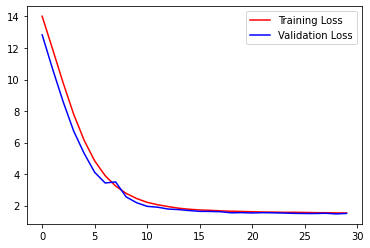

In [49]:
plt.plot(history.history["loss"],'r', label="Training Loss")
plt.plot(history.history["val_loss"],'b', label="Validation Loss")
plt.legend()

In [50]:
test_loss,test_acc=model.evaluate(X_test,y_test,verbose=3)
test_loss,test_acc

(1.5082744359970093, 0.5991827845573425)

In [51]:
predictions=model.predict(X_test)

169/169 [==============================] - 1s 6ms/step


In [52]:
print(confusion_matrix(np.argmax(y_test, axis = 1 ), np.argmax(model.predict(X_test),axis=1)))

169/169 [==============================] - 1s 6ms/step
[[ 369    6   18   66   77   11  226]
 [  26   12    2   13    7    2   16]
 [ 101    1  172   67  176   72  207]
 [  16    0   10 1199   13   24   74]
 [  58    3   27   93  358    6  359]
 [  21    0   43   36    5  407   52]
 [  19    0    5  120   71    9  709]]


In [53]:
print(classification_report(np.argmax(y_test, axis = 1 ), np.argmax(model.predict(X_test),axis=1)))

169/169 [==============================] - 1s 6ms/step
              precision    recall  f1-score   support

           0       0.60      0.48      0.53       773
           1       0.55      0.15      0.24        78
           2       0.62      0.22      0.32       796
           3       0.75      0.90      0.82      1336
           4       0.51      0.40      0.44       904
           5       0.77      0.72      0.74       564
           6       0.43      0.76      0.55       933

    accuracy                           0.60      5384
   macro avg       0.60      0.52      0.52      5384
weighted avg       0.61      0.60      0.58      5384



### VGG16

In [30]:
a=np.zeros((35887,48,48,3))
b=np.zeros((35887,48,48,3))

for i in range(35887):
  for j in range(48):
    for k in range(48):
      a[i][j][k][0]=train_pixels[i][j][k][0]
      a[i][j][k][1]=train_pixels[i][j][k][0]
      a[i][j][k][2]=train_pixels[i][j][k][0]
      

In [31]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(a, labels, test_size=0.15, shuffle=True)

In [32]:
train_datagen = ImageDataGenerator(width_shift_range = 0.1,
                               height_shift_range = 0.1,
                               shear_range=0.2,
                               horizontal_flip = True,
                               vertical_flip=True,
                               zoom_range = 0.2)
test_datagen = ImageDataGenerator() 

train_datagen.fit(X_train1)
test_datagen.fit(X_test1)

train_generator = train_datagen.flow(X_train1, y_train1, batch_size=64)
val_generator = test_datagen.flow(X_test1, y_test1, batch_size=64)

In [33]:
from keras import layers
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation,GlobalMaxPooling2D
from keras import applications
from keras import optimizers
from keras.applications.vgg16 import VGG16
from keras.models import Model


input_shape = (48, 48, 3)
epochs = 40
batch_size = 32
pre_trained_model = VGG16(input_shape=input_shape, include_top=False, weights="imagenet")

In [34]:
pre_trained_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [37]:
    
for layer in pre_trained_model.layers[:15]:
    layer.trainable = False

for layer in pre_trained_model.layers[15:]:
    layer.trainable = True
    
last_layer = pre_trained_model.get_layer('block5_pool')
last_output = last_layer.output
    
# Flatten the output layer to 1 dimension
x = GlobalMaxPooling2D()(last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = Dense(512, activation='relu')(x)
# Add a dropout rate of 0.5
x = Dropout(0.5)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(7, activation='softmax')(x)

model1 = Model(pre_trained_model.input, x)

In [38]:
model1.compile(
    optimizer = Adam(lr=0.0001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])

model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [39]:
checkpointer = [EarlyStopping(monitor = 'val_accuracy', verbose = 1, 
                              restore_best_weights=True,mode="max",patience = 5),
                ModelCheckpoint('best_model.h5',monitor="val_accuracy",verbose=1,
                                save_best_only=True,mode="max")]

In [40]:
training = model1.fit(train_generator,
                   epochs=40,
                   validation_data=val_generator,
                   callbacks=[checkpointer])

Epoch 1/40
477/477 [==============================] - ETA: 0s - loss: 1.6770 - accuracy: 0.3335
Epoch 1: val_accuracy improved from -inf to 0.43221, saving model to best_model.h5
477/477 [==============================] - 40s 63ms/step - loss: 1.6770 - accuracy: 0.3335 - val_loss: 1.5042 - val_accuracy: 0.4322
Epoch 2/40
477/477 [==============================] - ETA: 0s - loss: 1.5495 - accuracy: 0.3984
Epoch 2: val_accuracy improved from 0.43221 to 0.45951, saving model to best_model.h5
477/477 [==============================] - 31s 65ms/step - loss: 1.5495 - accuracy: 0.3984 - val_loss: 1.4227 - val_accuracy: 0.4595
Epoch 3/40
477/477 [==============================] - ETA: 0s - loss: 1.4889 - accuracy: 0.4324
Epoch 3: val_accuracy improved from 0.45951 to 0.47084, saving model to best_model.h5
477/477 [==============================] - 29s 61ms/step - loss: 1.4889 - accuracy: 0.4324 - val_loss: 1.3901 - val_accuracy: 0.4708
Epoch 4/40
477/477 [==============================] - ETA:

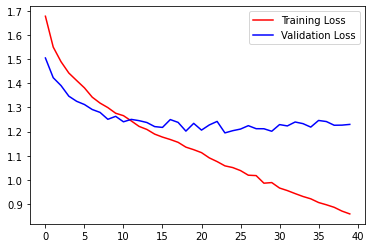

In [42]:
plt.plot(training.history["loss"],'r', label="Training Loss")
plt.plot(training.history["val_loss"],'b', label="Validation Loss")
plt.legend()

In [43]:
test_loss,test_acc=model1.evaluate(X_test1,y_test1,verbose=3)
test_loss,test_acc

(1.2295411825180054, 0.5731797814369202)

In [44]:
predictions=model1.predict(X_test1)

169/169 [==============================] - 2s 12ms/step


In [45]:
print(confusion_matrix(np.argmax(y_test1, axis = 1 ), np.argmax(model1.predict(X_test1),axis=1)))

169/169 [==============================] - 3s 12ms/step
[[ 269   14   92   74  105   21  164]
 [   5   44    3    6    5    1    7]
 [  57    6  318   66  120   56  113]
 [  50    6   54 1102   57   34  116]
 [  56    6  107   99  372   22  212]
 [  20    0   67   46   13  417   55]
 [  40    6   56  112  116   33  564]]


In [46]:
print(classification_report(np.argmax(y_test1, axis = 1 ), np.argmax(model1.predict(X_test1),axis=1)))

169/169 [==============================] - 2s 12ms/step
              precision    recall  f1-score   support

           0       0.54      0.36      0.44       739
           1       0.54      0.62      0.58        71
           2       0.46      0.43      0.44       736
           3       0.73      0.78      0.75      1419
           4       0.47      0.43      0.45       874
           5       0.71      0.67      0.69       618
           6       0.46      0.61      0.52       927

    accuracy                           0.57      5384
   macro avg       0.56      0.56      0.55      5384
weighted avg       0.57      0.57      0.57      5384

